# Kernel Comparison for KLRfome

This notebook compares different kernel approaches for distribution regression in KLRfome.

## Available Kernels

| Kernel | `kernel_type` | Description | Best For |
|--------|--------------|-------------|----------|
| **Mean Embedding** | `'mean_embedding'` | Similarity via inner product of mean embeddings in RKHS | Distributions that differ by location/mean |
| **Wasserstein** | `'wasserstein'` | RBF kernel on Sliced Wasserstein distance | Distributions with similar means but different shapes |

This notebook is designed to be extended as new kernels are added.


In [41]:
import sys
sys.path.insert(0, '..')

import jax.numpy as jnp
import jax.random as random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
import rasterio
import rasterio.transform
from rasterio.transform import from_bounds
import geopandas as gpd
from shapely.geometry import Point
import time
from dataclasses import dataclass
from typing import Dict, List, Callable

from klrfome import KLRfome, RasterStack, TrainingData, SampleCollection
from klrfome.data.simulation import sim_trend, rescale_sim_raster, nlm_gaussianfield
from klrfome.visualization import plot_predictions

print("KLRfome Kernel Comparison Notebook")
print("=" * 40)

KLRfome Kernel Comparison Notebook


## 1. Define Kernel Configurations

Each kernel configuration is defined as a dictionary. Add new kernels here as they become available.


In [42]:
# Define kernel configurations to compare
# Add new kernels here as they become available

KERNEL_CONFIGS = {
    'Mean Embedding (RFF)': {
        'kernel_type': 'mean_embedding',
        'n_rff_features': 256,
        'description': 'Mean embedding with Random Fourier Features approximation',
        'color': '#2E86AB'  # Blue
    },
    'Mean Embedding (Exact)': {
        'kernel_type': 'mean_embedding',
        'n_rff_features': 0,
        'description': 'Mean embedding with exact kernel computation',
        'color': '#1B4965'  # Dark blue
    },
    'Wasserstein (p=2)': {
        'kernel_type': 'wasserstein',
        'n_projections': 100,
        'wasserstein_p': 2,
        'description': 'Sliced Wasserstein kernel with p=2 (Euclidean)',
        'color': '#A23B72'  # Magenta
    },
    'Wasserstein (p=1)': {
        'kernel_type': 'wasserstein',
        'n_projections': 100,
        'wasserstein_p': 1,
        'description': 'Sliced Wasserstein kernel with p=1 (Manhattan)',
        'color': '#F18F01'  # Orange
    },
    # Add new kernels here:
    # 'New Kernel': {
    #     'kernel_type': 'new_kernel_type',
    #     'param': value,
    #     'description': 'Description of new kernel',
    #     'color': '#HEXCODE'
    # },
}

print(f"Comparing {len(KERNEL_CONFIGS)} kernel configurations:")
for name, config in KERNEL_CONFIGS.items():
    print(f"  - {name}: {config['description']}")


Comparing 4 kernel configurations:
  - Mean Embedding (RFF): Mean embedding with Random Fourier Features approximation
  - Mean Embedding (Exact): Mean embedding with exact kernel computation
  - Wasserstein (p=2): Sliced Wasserstein kernel with p=2 (Euclidean)
  - Wasserstein (p=1): Sliced Wasserstein kernel with p=1 (Manhattan)


## 2. Data Generation with Difficulty Levels

We use realistic spatial data generation (same as 01_quickstart) with configurable difficulty levels.

**Key Parameters:**
- `mix_strength`: Controls overlap between site/background conditions (lower = harder)
- `trend_power`: Controls concentration of favorable areas (higher = more concentrated)
- `favor_threshold`: Sites placed in bottom X% of favorability
- `noise_level`: Random noise added to features

**Difficulty Presets:**
- **Easy**: High signal, low noise (AUC ~0.9)
- **Medium**: Moderate signal and noise (AUC ~0.7-0.8)
- **Hard**: Low signal, high noise (AUC ~0.6-0.7)

In [43]:
def generate_realistic_scenario(
    difficulty='medium',
    cols=100,
    rows=100,
    n_sites=20,
    n_features=3,
    autocorr_range=15,
    seed=42
):
    """Generate realistic spatial data with controlled difficulty.
    
    Returns:
        raster_stack: RasterStack with spatially autocorrelated features
        sites_gdf: GeoDataFrame with site locations
        transform: Rasterio affine transform
    """
    # Difficulty parameter presets
    difficulty_params = {
        'easy': {
            'mix_strength': 0.5,
            'trend_power': 1.5,
            'favor_threshold': 0.6,
            'noise_level': 0.05
        },
        'medium': {
            'mix_strength': 0.3,
            'trend_power': 1.0,
            'favor_threshold': 0.5,
            'noise_level': 0.15
        },
        'hard': {
            'mix_strength': 0.2,
            'trend_power': 0.7,
            'favor_threshold': 0.4,
            'noise_level': 0.25
        }
    }
    params = difficulty_params[difficulty]
    
    # Step 1: Create site-likely rasters (conditions favorable for sites)
    s_var1r = nlm_gaussianfield(cols, rows, autocorr_range=autocorr_range, seed=seed)
    vars_site = []
    scales = [(60, 15), (4, 2), (6, 1.5)]  # (mean, sd) for each feature
    for i in range(n_features):
        if i < len(scales):
            vars_site.append(rescale_sim_raster(s_var1r, scales[i][0], scales[i][1]))
        else:
            vars_site.append(rescale_sim_raster(s_var1r, 50, 10))
    
    # Step 2: Create site-unlikely rasters (background conditions)
    b_var1r = nlm_gaussianfield(cols, rows, autocorr_range=autocorr_range, seed=seed + 1000)
    vars_bg = []
    bg_scales = [(80, 15), (5, 2), (8, 1.5)]
    for i in range(n_features):
        if i < len(bg_scales):
            vars_bg.append(rescale_sim_raster(b_var1r, bg_scales[i][0], bg_scales[i][1]))
        else:
            vars_bg.append(rescale_sim_raster(b_var1r, 70, 10))
    
    # Step 3: Place sites in favorable areas
    favorability_surface = s_var1r
    trend_result = sim_trend(
        cols, rows,
        n=n_sites,
        size=6,
        seed=seed,
        favorable_surface=favorability_surface,
        favor_threshold=params['favor_threshold']
    )
    trend = trend_result['trend']
    site_coords_pixels = trend_result['coords']
    
    # Step 4: Apply trend power
    trend = np.power(trend, params['trend_power'])
    inv_trend = 1 - trend
    
    # Step 5: Combine rasters with controlled mixing
    combined_vars = []
    for i in range(n_features):
        mix = params['mix_strength']
        combined = (vars_site[i] * (trend * mix + (1 - mix) * 0.5)) + \
                   (vars_bg[i] * (inv_trend * mix + (1 - mix) * 0.5))
        combined_vars.append(combined)
    
    # Step 6: Add random noise
    np.random.seed(seed)
    for i in range(n_features):
        noise = np.random.normal(0, params['noise_level'] * np.std(combined_vars[i]), 
                                combined_vars[i].shape)
        combined_vars[i] = combined_vars[i] + noise
    
    # Step 7: Create RasterStack
    data = jnp.array(combined_vars)
    transform = from_bounds(0, 0, 1, 1, cols, rows)
    band_names = [f'var{i+1}' for i in range(n_features)]
    
    raster_stack = RasterStack(
        data=data,
        transform=transform,
        crs="EPSG:4326",
        band_names=band_names
    )
    
    # Step 8: Convert pixel coordinates to geographic coordinates
    site_points = []
    for coord in site_coords_pixels:
        # sim_trend returns (col, row), transform.xy expects (row, col)
        x, y = rasterio.transform.xy(transform, coord[1], coord[0])
        site_points.append(Point(x, y))
    
    sites_gdf = gpd.GeoDataFrame(geometry=site_points, crs=raster_stack.crs)
    
    return raster_stack, sites_gdf, transform


# Define scenarios to test
SCENARIOS = [
    {
        'name': 'Easy',
        'difficulty': 'easy',
        'description': 'High signal, low noise. Strong separation expected.',
        'expected_range': (0.85, 0.95)
    },
    {
        'name': 'Medium',
        'difficulty': 'medium',
        'description': 'Moderate signal and noise. Realistic challenge.',
        'expected_range': (0.70, 0.85)
    },
    {
        'name': 'Hard',
        'difficulty': 'hard',
        'description': 'Low signal, high noise. Challenging separation.',
        'expected_range': (0.60, 0.75)
    }
]

print(f"Defined {len(SCENARIOS)} test scenarios:")
for s in SCENARIOS:
    print(f"  - {s['name']}: {s['description']}")
    print(f"    Expected AUC: {s['expected_range'][0]:.2f}-{s['expected_range'][1]:.2f}")

Defined 3 test scenarios:
  - Easy: High signal, low noise. Strong separation expected.
    Expected AUC: 0.85-0.95
  - Medium: Moderate signal and noise. Realistic challenge.
    Expected AUC: 0.70-0.85
  - Hard: Low signal, high noise. Challenging separation.
    Expected AUC: 0.60-0.75


## 3. Data Preparation and Scaling

Z-score normalization is critical for kernel methods to work properly!

In [44]:
from sklearn.metrics import confusion_matrix, f1_score

@dataclass
class KernelResult:
    """Results from evaluating a kernel on a dataset."""
    kernel_name: str
    # Test set metrics
    auc: float
    sensitivity: float
    specificity: float
    f1: float
    youdens_j: float
    optimal_threshold: float
    # Training set metrics
    train_auc: float
    train_sensitivity: float
    train_specificity: float
    train_f1: float
    # Timing
    fit_time: float
    predict_time: float
    # Convergence
    converged: bool
    n_iterations: int
    # Predictions
    train_predictions: np.ndarray
    train_labels: np.ndarray
    test_predictions: np.ndarray
    test_labels: np.ndarray
    raster_predictions: np.ndarray = None

print("KernelResult dataclass defined!")

KernelResult dataclass defined!


In [45]:
def prepare_and_scale_data(raster_stack, sites_gdf, n_background=50, samples_per_location=25, seed=42):
    """Prepare training data with proper scaling.
    
    Returns:
        training_data: Scaled TrainingData object
        scaled_raster_stack: Scaled RasterStack for predictions
        means: Feature means (for inverse transform if needed)
        sds: Feature standard deviations
    """
    # Initialize temporary model just for prepare_data
    temp_model = KLRfome(seed=seed)
    
    # Extract raw training data
    raw_training_data = temp_model.prepare_data(
        raster_stack=raster_stack,
        sites=sites_gdf,
        n_background=n_background,
        samples_per_location=samples_per_location,
        site_buffer=0.01,
        background_exclusion_buffer=0.02
    )
    
    # CRITICAL: Z-score normalization
    all_samples = np.vstack([np.array(c.samples) for c in raw_training_data.collections])
    means = np.mean(all_samples, axis=0)
    sds = np.std(all_samples, axis=0)
    sds = np.where(sds < 1e-10, 1.0, sds)  # Avoid division by zero
    
    # Scale collections
    def scale_collection(coll):
        scaled_samples = (jnp.array(coll.samples) - jnp.array(means)) / jnp.array(sds)
        return SampleCollection(
            samples=scaled_samples,
            label=coll.label,
            id=coll.id,
            metadata=coll.metadata
        )
    
    scaled_collections = [scale_collection(c) for c in raw_training_data.collections]
    training_data = TrainingData(
        collections=scaled_collections,
        feature_names=raw_training_data.feature_names,
        crs=raw_training_data.crs
    )
    
    # Scale raster stack using same parameters
    scaled_data = np.zeros_like(raster_stack.data)
    for i in range(raster_stack.n_bands):
        scaled_data[i] = (raster_stack.data[i] - means[i]) / sds[i]
    
    scaled_raster_stack = RasterStack(
        data=scaled_data,
        transform=raster_stack.transform,
        crs=raster_stack.crs,
        band_names=raster_stack.band_names
    )
    
    return training_data, scaled_raster_stack, means, sds


def extract_predictions_at_sites(predictions, sites_gdf, transform, n_background=500, window_size=2, seed=42):
    """Extract predictions at site locations and random background points.
    
    Returns:
        site_predictions: List of predictions at site locations
        background_predictions: List of predictions at random background locations
    """
    np.random.seed(seed)
    
    # Site predictions (with buffer window)
    site_predictions = []
    for _, row in sites_gdf.iterrows():
        geom = row.geometry
        row_idx, col = rasterio.transform.rowcol(transform, geom.x, geom.y)
        if 0 <= row_idx < predictions.shape[0] and 0 <= col < predictions.shape[1]:
            row_start = max(0, row_idx - window_size)
            row_end = min(predictions.shape[0], row_idx + window_size + 1)
            col_start = max(0, col - window_size)
            col_end = min(predictions.shape[1], col + window_size + 1)
            window_preds = predictions[row_start:row_end, col_start:col_end]
            site_predictions.extend(window_preds.flatten().tolist())
    
    # Random background predictions
    background_predictions = []
    for _ in range(n_background):
        row = np.random.randint(0, predictions.shape[0])
        col = np.random.randint(0, predictions.shape[1])
        background_predictions.append(float(predictions[row, col]))
    
    return site_predictions, background_predictions


print("Data preparation functions defined!")

Data preparation functions defined!


## 4. Evaluation Functions

Functions to evaluate kernels and logistic regression baseline.

In [46]:
def compute_metrics(labels, predictions, name=""):
    """Compute comprehensive classification metrics.
    
    Returns dict with: auc, sensitivity, specificity, f1, youdens_j, optimal_threshold
    """
    from sklearn.metrics import roc_curve, roc_auc_score, f1_score, confusion_matrix
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    auc = roc_auc_score(labels, predictions)
    
    # Find optimal threshold using Youden's J statistic
    youdens_j_scores = tpr - fpr
    optimal_idx = np.argmax(youdens_j_scores)
    optimal_threshold = thresholds[optimal_idx]
    youdens_j = youdens_j_scores[optimal_idx]
    
    # Compute metrics at optimal threshold
    binary_preds = (predictions >= optimal_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(labels, binary_preds).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    f1 = f1_score(labels, binary_preds)
    
    return {
        'auc': auc,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'f1': f1,
        'youdens_j': youdens_j,
        'optimal_threshold': optimal_threshold,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    }

print("Metrics computation function defined!")

Metrics computation function defined!


In [47]:
def evaluate_kernel(kernel_name, config, training_data, raster_stack, sites_gdf, transform, sigma=0.5, lambda_reg=0.1, window_size=5):
    """Evaluate a single kernel configuration using raster predictions."""
    
    # Build full model config
    model_kwargs = {
        'sigma': sigma,
        'lambda_reg': lambda_reg,
        'window_size': window_size,
        'seed': 42
    }
    for key, value in config.items():
        if key not in ['description', 'color']:
            model_kwargs[key] = value
    
    # Create and fit model
    model = KLRfome(**model_kwargs)
    start_time = time.time()
    model.fit(training_data)
    fit_time = time.time() - start_time
    
    # Training set predictions
    K = model._similarity_matrix
    alpha = model._fit_result.alpha
    eta = jnp.dot(K, alpha)
    train_probs = np.array(1.0 / (1.0 + jnp.exp(-eta)))
    train_labels = np.array([c.label for c in training_data.collections])
    
    # Compute training metrics
    train_metrics = compute_metrics(train_labels, train_probs, name=f"{kernel_name}_train")
    
    # Generate prediction raster
    predict_start = time.time()
    predictions = model.predict(raster_stack, batch_size=1000, show_progress=False)
    predict_time = time.time() - predict_start
    
    # Extract predictions at site locations and background (TEST SET)
    site_preds, bg_preds = extract_predictions_at_sites(
        predictions, sites_gdf, transform, n_background=500, window_size=2
    )
    
    # Test set labels and predictions
    test_labels = np.array([1] * len(site_preds) + [0] * len(bg_preds))
    test_probs = np.array(site_preds + bg_preds)
    
    # Compute test metrics
    test_metrics = compute_metrics(test_labels, test_probs, name=f"{kernel_name}_test")
    
    return KernelResult(
        kernel_name=kernel_name,
        # Test metrics
        auc=test_metrics['auc'],
        sensitivity=test_metrics['sensitivity'],
        specificity=test_metrics['specificity'],
        f1=test_metrics['f1'],
        youdens_j=test_metrics['youdens_j'],
        optimal_threshold=test_metrics['optimal_threshold'],
        # Training metrics
        train_auc=train_metrics['auc'],
        train_sensitivity=train_metrics['sensitivity'],
        train_specificity=train_metrics['specificity'],
        train_f1=train_metrics['f1'],
        # Timing
        fit_time=fit_time,
        predict_time=predict_time,
        # Convergence
        converged=model._fit_result.converged,
        n_iterations=model._fit_result.n_iterations,
        # Predictions
        train_predictions=train_probs,
        train_labels=train_labels,
        test_predictions=test_probs,
        test_labels=test_labels,
        raster_predictions=np.array(predictions)
    )

print("Kernel evaluation function defined!")

Kernel evaluation function defined!


In [48]:
from sklearn.linear_model import LogisticRegression

def predict_lr_on_raster(lr_model, scaled_raster_stack, window_size=5):
    """Generate predictions using LR on focal window means."""
    n_bands, rows, cols = scaled_raster_stack.data.shape
    predictions = np.zeros((rows, cols))
    pad = window_size // 2
    
    # Pad raster
    padded = np.pad(scaled_raster_stack.data, 
                   ((0, 0), (pad, pad), (pad, pad)), 
                   mode='edge')
    
    for row in range(rows):
        for col in range(cols):
            # Extract focal window
            window = padded[:, row:row+window_size, col:col+window_size]
            # Compute mean across window
            window_mean = np.mean(window, axis=(1, 2))
            # Predict
            pred = lr_model.predict_proba(window_mean.reshape(1, -1))[0, 1]
            predictions[row, col] = pred
    
    return predictions


def evaluate_logistic_regression(training_data, raster_stack, sites_gdf, transform):
    """Evaluate logistic regression baseline."""
    
    # Extract mean vectors for each distribution
    X_train = np.array([np.mean(c.samples, axis=0) for c in training_data.collections])
    y_train = np.array([c.label for c in training_data.collections])
    
    # Fit LR
    start_time = time.time()
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)
    fit_time = time.time() - start_time
    
    # Training set predictions
    train_probs = lr.predict_proba(X_train)[:, 1]
    train_metrics = compute_metrics(y_train, train_probs, name="LR_train")
    
    # Raster predictions
    predict_start = time.time()
    predictions = predict_lr_on_raster(lr, raster_stack, window_size=5)
    predict_time = time.time() - predict_start
    
    # Extract predictions at sites and background (TEST SET)
    site_preds, bg_preds = extract_predictions_at_sites(
        predictions, sites_gdf, transform, n_background=500, window_size=2
    )
    
    # Test set labels and predictions
    test_labels = np.array([1] * len(site_preds) + [0] * len(bg_preds))
    test_probs = np.array(site_preds + bg_preds)
    
    # Compute test metrics
    test_metrics = compute_metrics(test_labels, test_probs, name="LR_test")
    
    return KernelResult(
        kernel_name='Logistic Regression',
        # Test metrics
        auc=test_metrics['auc'],
        sensitivity=test_metrics['sensitivity'],
        specificity=test_metrics['specificity'],
        f1=test_metrics['f1'],
        youdens_j=test_metrics['youdens_j'],
        optimal_threshold=test_metrics['optimal_threshold'],
        # Training metrics
        train_auc=train_metrics['auc'],
        train_sensitivity=train_metrics['sensitivity'],
        train_specificity=train_metrics['specificity'],
        train_f1=train_metrics['f1'],
        # Timing
        fit_time=fit_time,
        predict_time=predict_time,
        # Convergence
        converged=True,
        n_iterations=lr.n_iter_[0] if hasattr(lr, 'n_iter_') else 0,
        # Predictions
        train_predictions=train_probs,
        train_labels=y_train,
        test_predictions=test_probs,
        test_labels=test_labels,
        raster_predictions=np.array(predictions)
    )


print("Logistic regression baseline defined!")

Logistic regression baseline defined!


## 5. Run Comparisons

Run all kernels + logistic regression on each scenario.

In [49]:
# Run comparison for the Medium scenario (change to test Easy or Hard)
scenario = SCENARIOS[1]  # 0=Easy, 1=Medium, 2=Hard

print(f"\n{'='*70}")
print(f"Running Scenario: {scenario['name']}")
print(f"{'='*70}\n")

# Generate data
raster_stack, sites_gdf, transform = generate_realistic_scenario(
    difficulty=scenario['difficulty'],
    seed=42
)

# Prepare and scale data
training_data, scaled_raster_stack, means, sds = prepare_and_scale_data(
    raster_stack, sites_gdf, n_background=50, samples_per_location=25
)

print(f"Data prepared:")
print(f"  Raster: {raster_stack.data.shape[1:]} ({raster_stack.n_bands} bands)")
print(f"  Sites: {len(sites_gdf)}")
print(f"  Training collections: {training_data.n_locations}")
print(f"  Total training samples: {sum(len(c.samples) for c in training_data.collections)}")

# Run all kernels
print(f"\n{'='*70}")
print("Evaluating Kernels...")
print(f"{'='*70}\n")

kernel_results = {}
print(f"{'Model':<30} {'Test AUC':<10} {'Fit Time':<12} {'Pred Time':<12}")
print("-" * 65)

for name, config in KERNEL_CONFIGS.items():
    result = evaluate_kernel(
        name, config, training_data, scaled_raster_stack, 
        sites_gdf, transform, sigma=0.5
    )
    kernel_results[name] = result
    print(f"{name:<30} {result.auc:<10.4f} {result.fit_time:<12.3f}s {result.predict_time:<12.3f}s")

# Run logistic regression baseline
print(f"\nEvaluating Logistic Regression Baseline...")
lr_result = evaluate_logistic_regression(
    training_data, scaled_raster_stack, sites_gdf, transform
)
kernel_results['Logistic Regression'] = lr_result
print(f"{'Logistic Regression':<30} {lr_result.auc:<10.4f} {lr_result.fit_time:<12.3f}s {lr_result.predict_time:<12.3f}s")

# Find best model
print("\n" + "=" * 75)
best = max(kernel_results.values(), key=lambda r: r.auc)
print(f"Best Model: {best.kernel_name} (Test AUC={best.auc:.4f})")
print(f"Expected AUC range for {scenario['name']}: {scenario['expected_range'][0]:.2f}-{scenario['expected_range'][1]:.2f}")
print("=" * 75)


Running Scenario: Medium

Data prepared:
  Raster: (100, 100) (3 bands)
  Sites: 20
  Training collections: 70
  Total training samples: 1750

Evaluating Kernels...

Model                          Test AUC   Fit Time     Pred Time   
-----------------------------------------------------------------
Mean Embedding (RFF)           0.7242     0.066       s 0.014       s
Mean Embedding (Exact)         0.7478     5.357       s 170.386     s
Wasserstein (p=2)              0.6548     0.043       s 0.019       s
Wasserstein (p=1)              0.6697     0.052       s 0.027       s

Evaluating Logistic Regression Baseline...
Logistic Regression            0.7225     0.003       s 1.278       s

Best Model: Mean Embedding (Exact) (Test AUC=0.7478)
Expected AUC range for Medium: 0.70-0.85


### 5.1 Comprehensive Metrics Table

Detailed performance metrics for all models on training and test sets.

In [50]:
# Create comprehensive metrics table
import pandas as pd

print("\n" + "="*120)
print("COMPREHENSIVE METRICS TABLE")
print("="*120 + "\n")

# Test set metrics
print("TEST SET PERFORMANCE (Raster Predictions at Site/Background Locations)")
print("-"*120)
test_data = []
for name, result in kernel_results.items():
    test_data.append({
        'Model': name,
        'AUC': f"{result.auc:.4f}",
        'Sensitivity': f"{result.sensitivity:.4f}",
        'Specificity': f"{result.specificity:.4f}",
        'F1 Score': f"{result.f1:.4f}",
        "Youden's J": f"{result.youdens_j:.4f}",
        'Threshold': f"{result.optimal_threshold:.4f}"
    })

test_df = pd.DataFrame(test_data)
print(test_df.to_string(index=False))

# Training set metrics
print("\n\nTRAINING SET PERFORMANCE (Distribution-Level Predictions)")
print("-"*120)
train_data = []
for name, result in kernel_results.items():
    train_data.append({
        'Model': name,
        'AUC': f"{result.train_auc:.4f}",
        'Sensitivity': f"{result.train_sensitivity:.4f}",
        'Specificity': f"{result.train_specificity:.4f}",
        'F1 Score': f"{result.train_f1:.4f}"
    })

train_df = pd.DataFrame(train_data)
print(train_df.to_string(index=False))

# Summary
print("\n" + "="*120)
print("KEY INSIGHTS:")
print("="*120)
best_test = max(kernel_results.values(), key=lambda r: r.auc)
best_train = max(kernel_results.values(), key=lambda r: r.train_auc)
print(f"✓ Best Test AUC: {best_test.kernel_name} ({best_test.auc:.4f})")
print(f"✓ Best Train AUC: {best_train.kernel_name} ({best_train.train_auc:.4f})")
print(f"✓ Best Youden's J: {max(kernel_results.values(), key=lambda r: r.youdens_j).kernel_name} "
      f"({max(r.youdens_j for r in kernel_results.values()):.4f})")
print(f"✓ Best F1 Score: {max(kernel_results.values(), key=lambda r: r.f1).kernel_name} "
      f"({max(r.f1 for r in kernel_results.values()):.4f})")
print("="*120)


COMPREHENSIVE METRICS TABLE

TEST SET PERFORMANCE (Raster Predictions at Site/Background Locations)
------------------------------------------------------------------------------------------------------------------------
                 Model    AUC Sensitivity Specificity F1 Score Youden's J Threshold
  Mean Embedding (RFF) 0.7242      0.7280      0.6460   0.6993     0.3740    0.3421
Mean Embedding (Exact) 0.7478      0.9180      0.4800   0.7531     0.3980    0.3050
     Wasserstein (p=2) 0.6548      0.9060      0.4180   0.7283     0.3240    0.7346
     Wasserstein (p=1) 0.6697      0.9600      0.3700   0.7413     0.3300    0.5739
   Logistic Regression 0.7225      0.9640      0.4080   0.7543     0.3720    0.2396


TRAINING SET PERFORMANCE (Distribution-Level Predictions)
------------------------------------------------------------------------------------------------------------------------
                 Model    AUC Sensitivity Specificity F1 Score
  Mean Embedding (RFF) 0.8270 

## 6. Visualizations

### 6.1 Geographic Overview

Visualize predictions in geographic space.

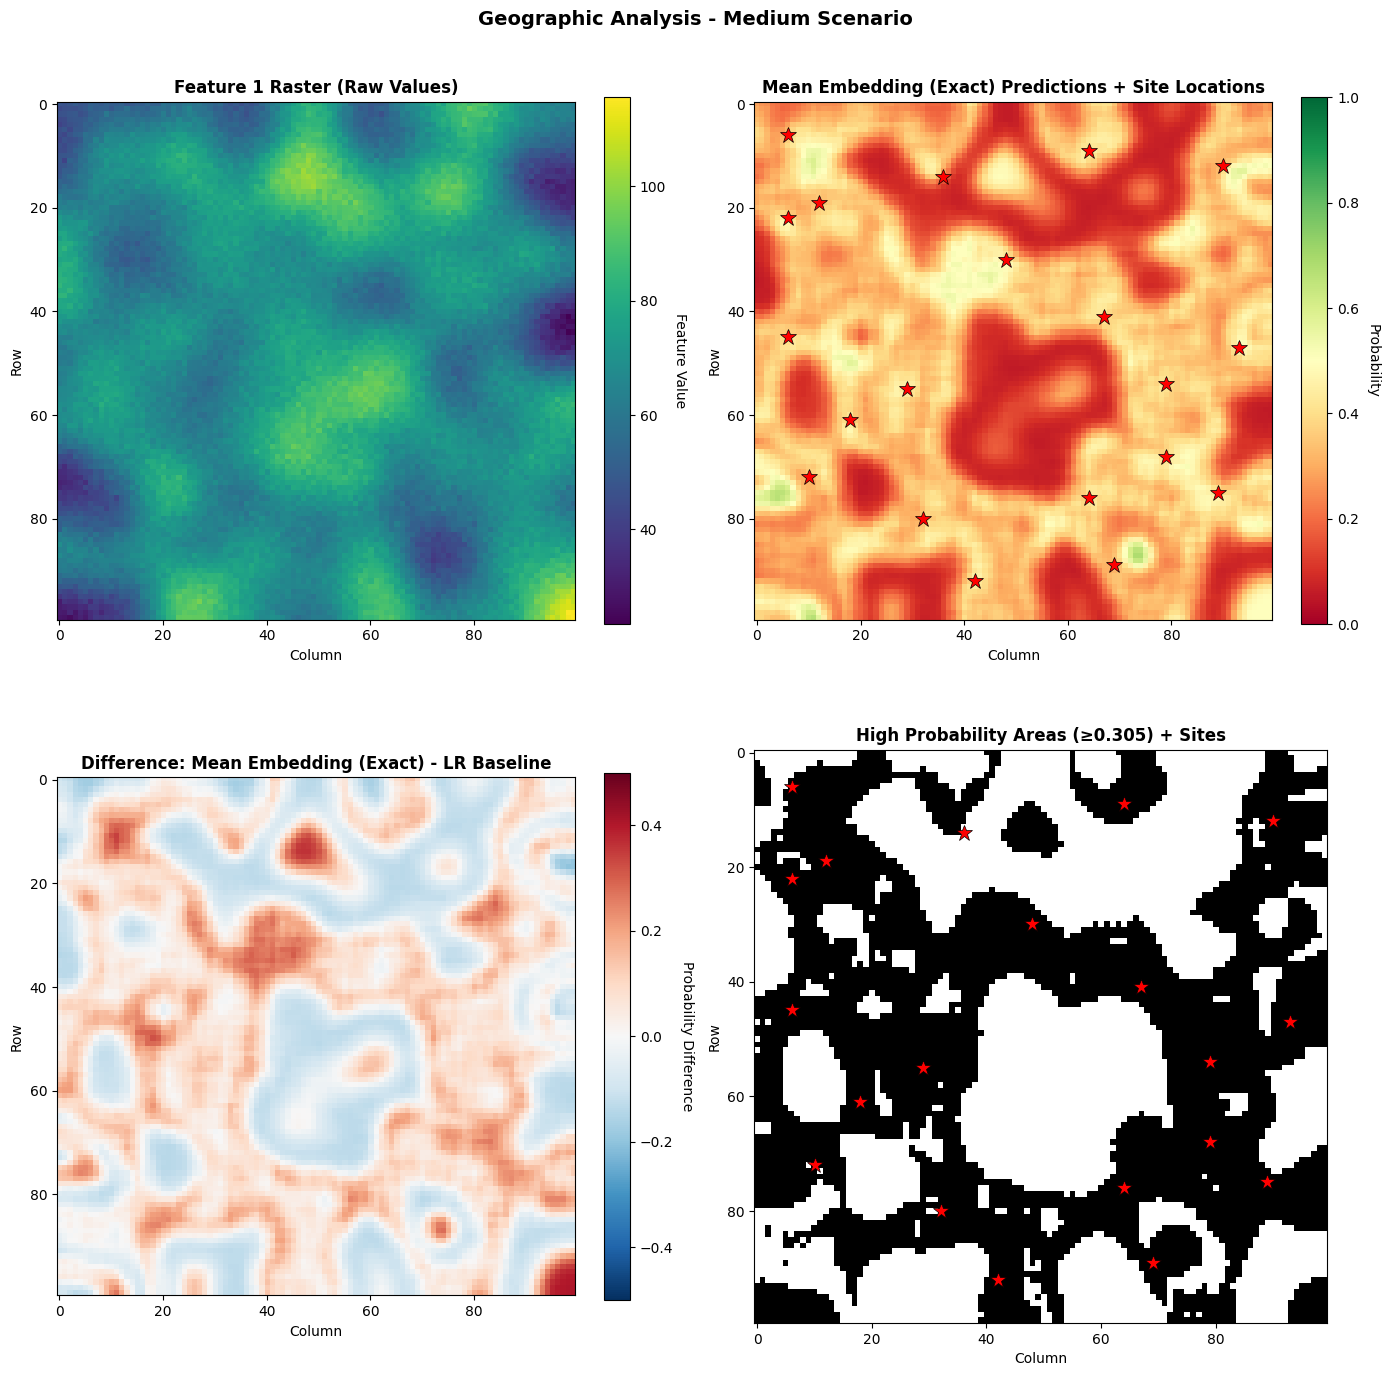


Optimal threshold (Youden's J): 0.3050
High probability coverage: 52.1% of landscape
Sites in high probability areas: 19/20


In [51]:
# Geographic visualization: 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Get best kernel predictions
best_kernel_preds = best.raster_predictions
lr_preds = kernel_results['Logistic Regression'].raster_predictions

# Top-left: Feature 1 raster (raw, unscaled)
axes[0, 0].imshow(raster_stack.data[0], cmap='viridis')
axes[0, 0].set_title('Feature 1 Raster (Raw Values)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Column')
axes[0, 0].set_ylabel('Row')
cbar = plt.colorbar(axes[0, 0].images[0], ax=axes[0, 0], fraction=0.046)
cbar.set_label('Feature Value', rotation=270, labelpad=15)

# Top-right: Best kernel predictions with site locations
im = axes[0, 1].imshow(best_kernel_preds, cmap='RdYlGn', vmin=0, vmax=1)
for _, row in sites_gdf.iterrows():
    row_idx, col = rasterio.transform.rowcol(transform, row.geometry.x, row.geometry.y)
    axes[0, 1].plot(col, row_idx, 'r*', markersize=12, markeredgecolor='black', markeredgewidth=0.5)
axes[0, 1].set_title(f'{best.kernel_name} Predictions + Site Locations', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Column')
axes[0, 1].set_ylabel('Row')
cbar = plt.colorbar(im, ax=axes[0, 1], fraction=0.046)
cbar.set_label('Probability', rotation=270, labelpad=15)

# Bottom-left: Difference map (best kernel - LR)
diff = best_kernel_preds - lr_preds
im_diff = axes[1, 0].imshow(diff, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
axes[1, 0].set_title(f'Difference: {best.kernel_name} - LR Baseline', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Column')
axes[1, 0].set_ylabel('Row')
cbar = plt.colorbar(im_diff, ax=axes[1, 0], fraction=0.046)
cbar.set_label('Probability Difference', rotation=270, labelpad=15)

# Bottom-right: High probability areas using optimal threshold
optimal_thresh = best.optimal_threshold
high_prob = best_kernel_preds >= optimal_thresh
axes[1, 1].imshow(high_prob, cmap='gray_r')
# Overlay site locations
for _, row in sites_gdf.iterrows():
    row_idx, col = rasterio.transform.rowcol(transform, row.geometry.x, row.geometry.y)
    axes[1, 1].plot(col, row_idx, 'r*', markersize=12, markeredgecolor='black', markeredgewidth=0.5)
axes[1, 1].set_title(f'High Probability Areas (≥{optimal_thresh:.3f}) + Sites', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Column')
axes[1, 1].set_ylabel('Row')

plt.suptitle(f'Geographic Analysis - {scenario["name"]} Scenario', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\nOptimal threshold (Youden's J): {optimal_thresh:.4f}")
print(f"High probability coverage: {np.sum(high_prob) / high_prob.size * 100:.1f}% of landscape")
print(f"Sites in high probability areas: {sum(1 for _, site_row in sites_gdf.iterrows() if best_kernel_preds[rasterio.transform.rowcol(transform, site_row.geometry.x, site_row.geometry.y)] >= optimal_thresh)}/{len(sites_gdf)}")

### 6.2 Per-Model Prediction Rasters

Compare prediction rasters across all models with training site locations.

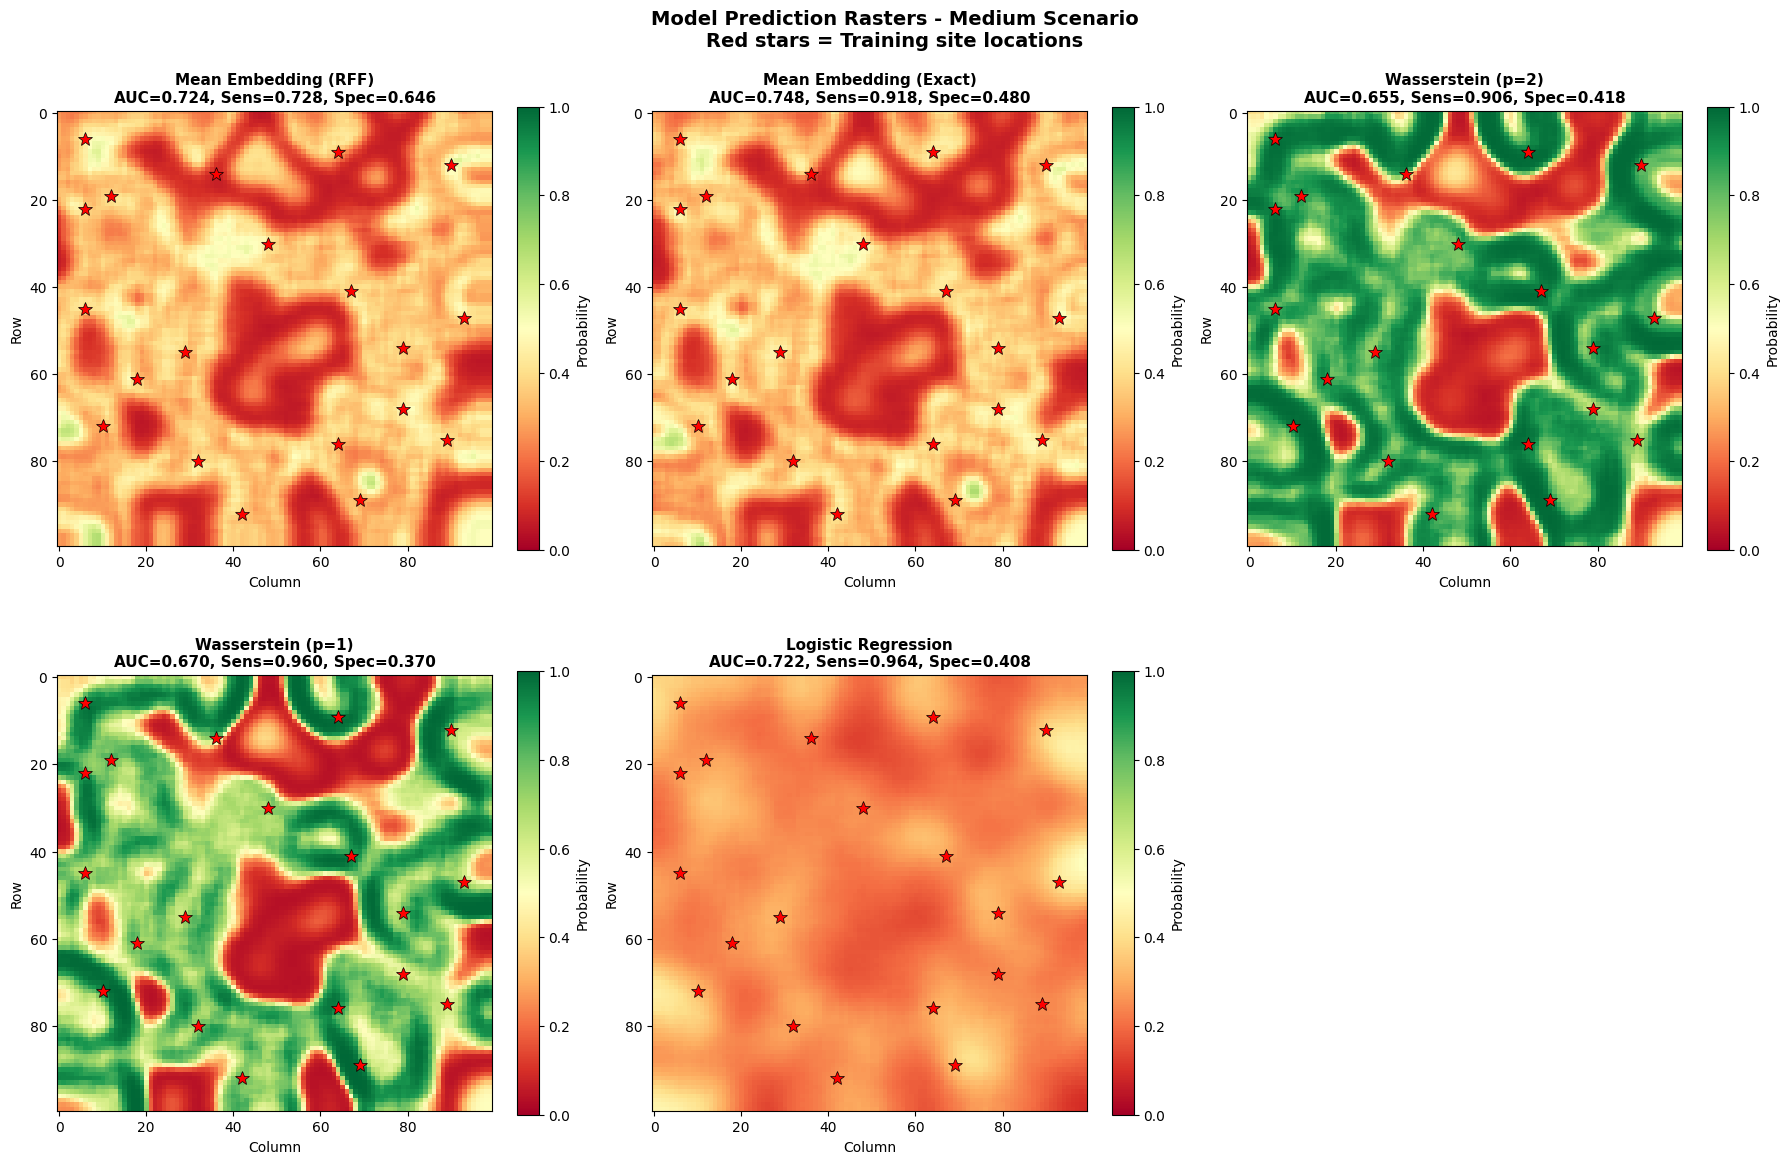


Prediction Statistics by Model:

Mean Embedding (RFF):
  Mean prediction: 0.2867
  Std prediction:  0.1211
  Min prediction:  0.0485
  Max prediction:  0.6744
  Optimal threshold: 0.3421
  Coverage at threshold: 37.9%

Mean Embedding (Exact):
  Mean prediction: 0.2837
  Std prediction:  0.1229
  Min prediction:  0.0531
  Max prediction:  0.6821
  Optimal threshold: 0.3050
  Coverage at threshold: 52.1%

Wasserstein (p=2):
  Mean prediction: 0.6723
  Std prediction:  0.3210
  Min prediction:  0.0407
  Max prediction:  0.9928
  Optimal threshold: 0.7346
  Coverage at threshold: 61.6%

Wasserstein (p=1):
  Mean prediction: 0.5913
  Std prediction:  0.3086
  Min prediction:  0.0363
  Max prediction:  0.9989
  Optimal threshold: 0.5739
  Coverage at threshold: 63.8%

Logistic Regression:
  Mean prediction: 0.2551
  Std prediction:  0.0582
  Min prediction:  0.0931
  Max prediction:  0.5088
  Optimal threshold: 0.2396
  Coverage at threshold: 59.3%


In [56]:
# Create grid of prediction rasters for all models
n_models = len(kernel_results)
ncols = min(3, n_models)
nrows = (n_models + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 6*nrows))
if n_models == 1:
    axes = [axes]
else:
    axes = axes.flatten() if nrows > 1 else axes

# Plot each model's predictions
for idx, (name, result) in enumerate(kernel_results.items()):
    ax = axes[idx]
    
    # Plot prediction raster
    im = ax.imshow(result.raster_predictions, cmap='RdYlGn', vmin=0, vmax=1)
    
    # Overlay training sites (red stars)
    for _, site_row in sites_gdf.iterrows():
        row_idx, col = rasterio.transform.rowcol(transform, site_row.geometry.x, site_row.geometry.y)
        ax.plot(col, row_idx, 'r*', markersize=10, markeredgecolor='black', markeredgewidth=0.5)
    
    # Title with metrics
    title = f'{name}\nAUC={result.auc:.3f}, Sens={result.sensitivity:.3f}, Spec={result.specificity:.3f}'
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    
    # Colorbar
    plt.colorbar(im, ax=ax, fraction=0.046, label='Probability')

# Hide extra subplots if any
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.suptitle(f'Model Prediction Rasters - {scenario["name"]} Scenario\nRed stars = Training site locations', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print prediction statistics for each model
print("\nPrediction Statistics by Model:")
print("="*80)
for name, result in kernel_results.items():
    preds = result.raster_predictions
    print(f"\n{name}:")
    print(f"  Mean prediction: {np.mean(preds):.4f}")
    print(f"  Std prediction:  {np.std(preds):.4f}")
    print(f"  Min prediction:  {np.min(preds):.4f}")
    print(f"  Max prediction:  {np.max(preds):.4f}")
    print(f"  Optimal threshold: {result.optimal_threshold:.4f}")
    print(f"  Coverage at threshold: {np.sum(preds >= result.optimal_threshold) / preds.size * 100:.1f}%")

### 6.3 Feature Space Analysis

Visualize distribution means in 2D feature space using PCA.

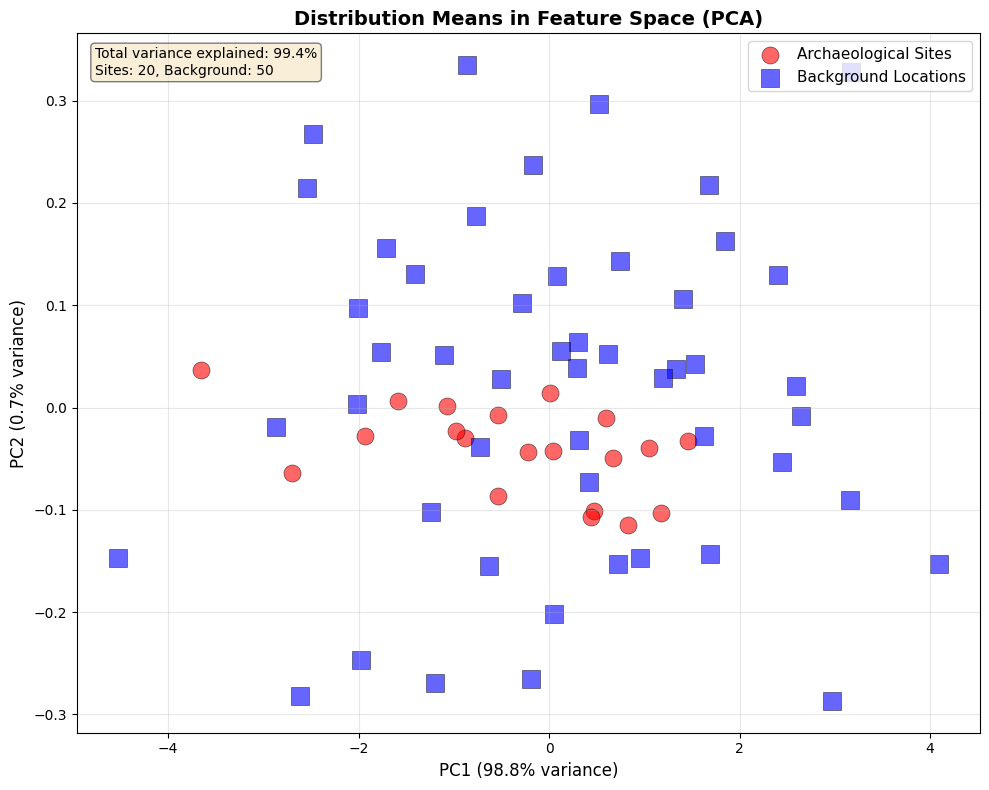


PCA Results:
  PC1 explains 98.8% of variance
  PC2 explains 0.7% of variance
  Total: 99.4% captured in 2D


In [57]:
# PCA on distribution means
means_array = np.array([np.mean(c.samples, axis=0) for c in training_data.collections])
labels_array = np.array([c.label for c in training_data.collections])

# Fit PCA
pca = PCA(n_components=2)
means_2d = pca.fit_transform(means_array)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Sites (label=1)
site_mask = labels_array == 1
ax.scatter(means_2d[site_mask, 0], means_2d[site_mask, 1],
           c='red', alpha=0.6, s=150, label='Archaeological Sites', 
           edgecolors='black', linewidths=0.5, marker='o')

# Background (label=0)
bg_mask = labels_array == 0
ax.scatter(means_2d[bg_mask, 0], means_2d[bg_mask, 1],
           c='blue', alpha=0.6, s=150, label='Background Locations', 
           edgecolors='black', linewidths=0.5, marker='s')

# Labels and formatting
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title('Distribution Means in Feature Space (PCA)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

# Add text with separation info
total_var = pca.explained_variance_ratio_[:2].sum()
ax.text(0.02, 0.98, f'Total variance explained: {total_var:.1%}\n'
                     f'Sites: {site_mask.sum()}, Background: {bg_mask.sum()}',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nPCA Results:")
print(f"  PC1 explains {pca.explained_variance_ratio_[0]:.1%} of variance")
print(f"  PC2 explains {pca.explained_variance_ratio_[1]:.1%} of variance")
print(f"  Total: {total_var:.1%} captured in 2D")

### 6.4 Feature Distribution Comparison

Compare the distributions of feature values at sites vs. background locations.

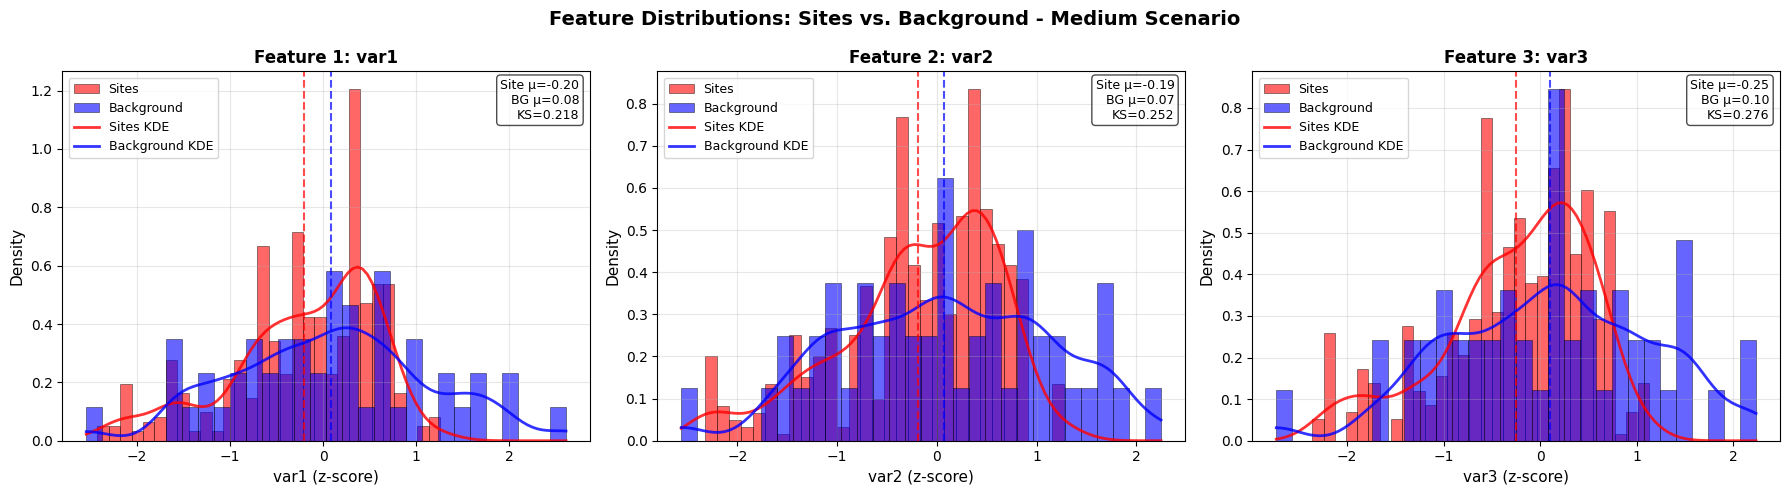


Distribution Statistics:
  var1: Site μ=-0.204, BG μ=0.082, KS statistic=0.218 (p=0.0000)
  var2: Site μ=-0.187, BG μ=0.075, KS statistic=0.252 (p=0.0000)
  var3: Site μ=-0.246, BG μ=0.098, KS statistic=0.276 (p=0.0000)


In [58]:
# Extract all samples for sites and background
n_features = training_data.collections[0].samples.shape[1]

site_samples = np.concatenate([
    np.array(c.samples) for c in training_data.collections if c.label == 1
])

bg_samples = np.concatenate([
    np.array(c.samples) for c in training_data.collections if c.label == 0
])

# Create subplot for each feature
fig, axes = plt.subplots(1, n_features, figsize=(6 * n_features, 5))
if n_features == 1:
    axes = [axes]

for feat_idx in range(n_features):
    ax = axes[feat_idx]
    
    # Extract feature values
    site_vals = site_samples[:, feat_idx]
    bg_vals = bg_samples[:, feat_idx]
    
    # Plot histograms
    ax.hist(site_vals, bins=30, alpha=0.6, label='Sites', color='red', 
            density=True, edgecolor='black', linewidth=0.5)
    ax.hist(bg_vals, bins=30, alpha=0.6, label='Background', color='blue', 
            density=True, edgecolor='black', linewidth=0.5)
    
    # Add KDE curves
    from scipy.stats import gaussian_kde
    if len(site_vals) > 1:
        kde_site = gaussian_kde(site_vals)
        x_range = np.linspace(min(site_vals.min(), bg_vals.min()), 
                             max(site_vals.max(), bg_vals.max()), 100)
        ax.plot(x_range, kde_site(x_range), 'r-', linewidth=2, alpha=0.8, label='Sites KDE')
    
    if len(bg_vals) > 1:
        kde_bg = gaussian_kde(bg_vals)
        x_range = np.linspace(min(site_vals.min(), bg_vals.min()), 
                             max(site_vals.max(), bg_vals.max()), 100)
        ax.plot(x_range, kde_bg(x_range), 'b-', linewidth=2, alpha=0.8, label='Background KDE')
    
    # Statistics
    site_mean = np.mean(site_vals)
    bg_mean = np.mean(bg_vals)
    ax.axvline(site_mean, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.axvline(bg_mean, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # Labels and formatting
    ax.set_xlabel(f'{training_data.feature_names[feat_idx]} (z-score)', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'Feature {feat_idx+1}: {training_data.feature_names[feat_idx]}', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add stats text
    from scipy.stats import ks_2samp
    ks_stat, ks_pval = ks_2samp(site_vals, bg_vals)
    stats_text = f'Site μ={site_mean:.2f}\nBG μ={bg_mean:.2f}\nKS={ks_stat:.3f}'
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, 
            fontsize=9, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.suptitle(f'Feature Distributions: Sites vs. Background - {scenario["name"]} Scenario', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nDistribution Statistics:")
for feat_idx in range(n_features):
    site_vals = site_samples[:, feat_idx]
    bg_vals = bg_samples[:, feat_idx]
    from scipy.stats import ks_2samp
    ks_stat, ks_pval = ks_2samp(site_vals, bg_vals)
    print(f"  {training_data.feature_names[feat_idx]}: Site μ={np.mean(site_vals):.3f}, "
          f"BG μ={np.mean(bg_vals):.3f}, KS statistic={ks_stat:.3f} (p={ks_pval:.4f})")